# Parameter estimation example: fitting a straight line 

Adapted from BayesianAstronomy.
$% Some LaTeX definitions we'll use.
\newcommand{\pr}{{p}}
$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set('talk') # for plot formatting

## The Data

Let's start by creating some data that we will fit with a straight line.  We'll start with a constant standard deviation of $\sigma$ on the $y$ values and no error on $x$.

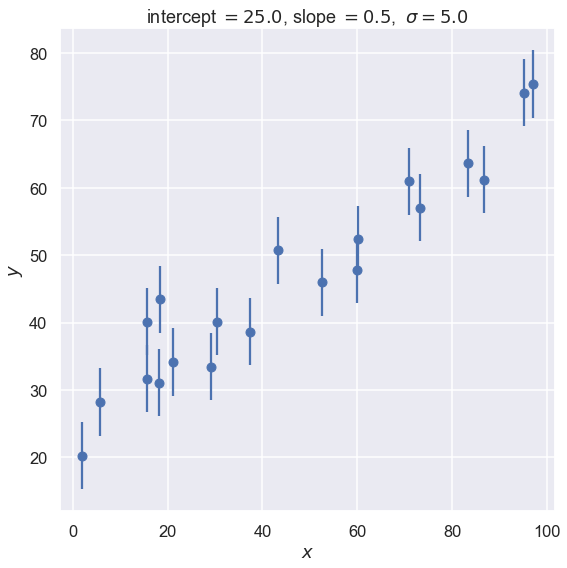

In [14]:
def make_data(intercept, slope, N=20, dy=5, rseed=10):
    """Given a straight line defined by intercept and slope:
          y = slope * x + intercept
       generate N points randomly spaced points from x=0 to x=100
       with Gaussian (i.e., normal) error with mean zero and standard
       deviation dy.
       
       Return the x and y arrays and an array of standard deviations.
    """
    rand = np.random.RandomState(rseed) 
    x = 100 * rand.rand(N)  # choose the x values randomly in [0,100]
    y = intercept + slope * x  # This is the y value without noise
    y += dy * rand.randn(N)    # Add in Gaussian noise
    return x, y, dy * np.ones_like(x)  # return coordinates and error bars

intercept = 25.   # true intercept (called b elsewhere)
slope = 0.5       # true slope (called m elsewhere)
theta_true = [intercept, slope]  # put parameters in a true theta vector
x, y, dy = make_data(*theta_true, rseed=42)

fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(x, y, dy, fmt='o')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plot_title = rf'intercept $= {intercept:.1f}$, slope $= {slope:.1f}$, ' \
              + rf' $\sigma = {dy[0]:.1f}$'
ax.set_title(plot_title)
fig.tight_layout()

## The Model

Next we need to specify a theoretical model. We're fitting a straight line to data, so we'll need a slope and an intercept; i.e.

$$
y_{\textrm{th}}(x) = mx + b
$$

where our parameter vector will be 

$$
\theta = [b, m]
$$

But this is only half the picture: what we mean by a "model" in a Bayesian sense is not only this expected value $y_{\textrm{th}}(x;\theta)$, but a **probability distribution** for our data.
That is, we need an expression to compute the likelihood $\pr(D\mid\theta, I)$ for our data as a function of the parameters $\theta$ ($I$ stands for all other information).
Here $D$ is the set of all $(x,y)$ pairs that we know about (or measure).

\[Note: At this stage we are (implicitly) assuming that our theoretical model is perfect.  But it is not!  We'll come back eventually to talk about adding a theory error $\delta y_{\textrm{th}}$.\]

We are given data with simple error bars, which imply that the probability for any *single* data point (labeled by $i$) is a normal distribution with mean given by the true value. That is,

$$
y_i \sim \mathcal{N}(y_{\textrm{th}}(x_i;\theta), \varepsilon_i^2)
$$

or, in other words,

$$
\pr(y_i\mid x_i,\theta,  I) = \frac{1}{\sqrt{2\pi\varepsilon_i^2}} \exp\left(\frac{-\left[y_i - y_{\textrm{th}}(x_i;\theta)\right]^2}{2\varepsilon_i^2}\right)
$$

where $\varepsilon_i$ are the (known) measurement errors indicated by the error bars.

Assuming all the points are independent, we can find the full likelihood by multiplying the individual likelihoods together:

$$
\pr(D\mid\theta, I) = \prod_{i=1}^N \pr(y_i\mid x_i,\theta, I)
$$

For convenience (and also for numerical accuracy) this is often expressed in terms of the log-likelihood:

$$
\log \pr(D\mid\theta, I) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\varepsilon_i^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\varepsilon_i^2}\right)
$$

###  Exercises

1. Write a Python function which computes the log-likelihood given a parameter vector $\theta$, an array of errors $\varepsilon$, and an array of $x$ and $y$ values

1. Use tools in [``scipy.optimize``](http://docs.scipy.org/doc/scipy/reference/optimize.html) to maximize this likelihood (i.e. minimize the negative log-likelihood). How close is this result to the input ``theta_true`` above?  Is that expected or unexpected?

1. Change the random number seed to get different results and comment on how the maximum likelihood results fluctuate? How are size of the fluctuations related to the number of data points $N$ and the data error standard deviation $dy$?  (Try changing them!)

In [15]:
# Either write your code here or study the sample solution that follows.

#### One solution (how could these functions be improved?)

In [16]:
def log_likelihood(theta, x, y, dy):
    """ 
    Return the log of the likelihood function, given a 2D array theta of
    parameters (b, m) and the x, y coordinates with standard deviation dy.
    """
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * dy**2) + (y - y_model)**2 / dy**2)

In [17]:
from scipy import optimize

def minfunc(theta, x, y, dy):
    """
    Function to be minimized: minus the logarithm of the likelihood.
    """
    return -log_likelihood(theta, x, y, dy)



result = optimize.minimize(minfunc, x0=[0, 0], args=(x, y, dy))

# try without np.printoptions to see what you get
with np.printoptions(precision=3, suppress=True):
    print(f'result: {result.x}')
    print(f'input:  {theta_true}')

result: [24.818  0.474]
input:  [25.0, 0.5]


## The Prior

We have computed the likelihood, now we need to think about the prior $\pr(\theta\mid I)$.

*So... what can we actually say about the slope and intercept before we fit our data?*

There are several approaches to choosing priors that you'll come across in practice.  Here we will just introduce some vocabulary and definitions and come back to details and options later.

1. **Conjugate priors.**
A [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) is a prior which, due to its mathematical relation to the likelihood, makes the result analytically computable.

2. **Empirical priors.** 
Empirical Priors are priors which are actually posteriors from previous studies of the same phenomenon. For example, it's common in Supernova cosmology studies to use the WMAP results as a prior: that is, to actually plug-in a *real result* and use the new data to improve on that. This situation is where Bayesian approaches really shine.  For the linear fit, you might imagine that the $x, y$ data is a more accurate version of a previous experiment, where we've found that the intercept is $\theta_0 = 50 \pm 30$ and the slope is $\theta_1 = 1.0 \pm 0.5$.
In this case, we'd encode this prior knowledge in the prior distribution itself.

3. **Flat priors.**
If you don't have an empirical prior, you might be tempted to simply use a *flat prior* – i.e. a prior that is constant between two reasonable limits (i.e. equal probability slopes from -1000 to +1000).  The problem is that flat priors are not always non-informative! For example, a flat prior on the slope will effectively give a higher weight to larger slopes.

4. **Non-informative priors.**
What we *really* want in cases where no empirical prior is available is a **non-informative prior**. Among other things, such a prior should not depend on the units of the data.
Perhaps the most principled approach to choosing non-informative priors was the *principle of maximum entropy* advocated by Jaynes ([book](http://omega.albany.edu:8008/JaynesBook.html)).
Similar in spirit is the commonly-used [Jeffreys Prior](https://en.wikipedia.org/wiki/Jeffreys_prior), which in many cases of interest amounts to a "scale invariant" prior: a flat prior on the logarithm of the parameter.
In the case of the linear slope, we often want a prior which does not artificially over-weight large slopes: there are a couple possible approaches to this (see http://arxiv.org/abs/1411.5018 for some discussion). For our situation, we might use a flat prior on the angle the line makes with the x-axis, which gives
$$
\pr(m) \propto (1 + m^2)^{-3/2}
$$
For lack of a better term, we will call this a "symmetric prior" on the slope (because it's the same whether we're fitting $y = mx + b$ or $x = m^\prime y + b^\prime$, which is the requirement leading to the functional form given).

5. **Weakly informative priors.**
See [Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) at the Stan github repository for a hierarchy of increasingly informative priors.


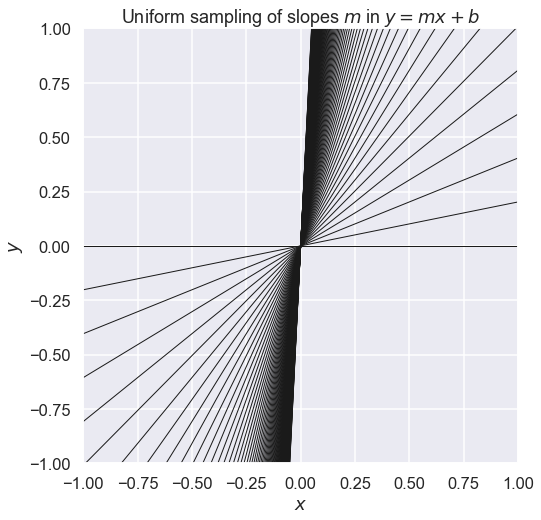

In [6]:
# see what happens if we sample from a uniform prior on the slope m
x_pts = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.axis([-1., 1., -1., 1.])
for slope in np.linspace(0, 20, 100):   # 20 evenly spaced slopes m
    ax.plot(x_pts, slope * x_pts, '-k', linewidth=1)
ax.set_xlabel(r'$x$')    
ax.set_ylabel(r'$y$')    
ax.set_title(r'Uniform sampling of slopes $m$ in $y= mx + b$')
ax.set_aspect(1)


### Implementation

Let's define two python functions to compute the options for our prior: we'll use both a (log) flat prior and a (log) symmetric prior.
In general, we need not worry about the normalization of the prior or the likelihood, which makes our lives easier:

In [7]:
def log_flat_prior(theta):
    """Flat prior on value of slope m"""
    if np.all(np.abs(theta) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_symmetric_prior(theta):
    """Prior p(m) proportional to (1 + m^2)^{-3/2}"""
    if np.abs(theta[0]) < 1000:
        return -1.5 * np.log(1 + theta[1]**2)
    else:
        return -np.inf  # log(0)

With these defined, we now have what we need to compute the log posterior as a function of the model parameters.
*You might be tempted to maximize this posterior in the same way that we did with the likelihood above, but this is not a Bayesian result!* The Bayesian result is a (possibly marginalized) posterior probability for our parameters.
The mode of a probability distribution is perhaps slightly informative, but it is in no way a Bayesian result.

Next you will plot the posterior probability as a function of the slope and intercept.

## Things to do:

1. Plot the posterior probability distribution for the slope and intercept, once for each prior. You might use ``plt.contourf()`` or ``plt.pcolor()``. How different are the two distributions?

1. Modify the dataset – how do your conclusions about the sensitivity to choice of prior change if you have very few data points or very large errors?

1. If you finish this quickly, try adding 1-sigma and 2-sigma contours to your plot, keeping in mind that the probabilities are not normalized. You can add them to your plot with ``plt.contour()``.  Note: this is non-trivial, but there is a short solution possible.

In [8]:
# Either write your code here or study the sample solution that follows.

#### One solution (how could this solution be improved?)

We'll start by defining a function which takes a two-dimensional grid of likelihoods and returns 1, 2, and 3-sigma contours. This acts by sorting and normalizing the values and then finding the locations of the  0.682 ,  0.952 , and  0.9972  cutoffs:

In [9]:
def contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior"""
    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997])**2)
    return np.sort(sorted_[cutoffs])

Now we define a function to compute and plot the results of the Bayesian analysis:

In [10]:
def plot_results(x, y, dy,
                 slope_limits=(0.3, 0.7),
                 intercept_limits=(15, 35)):
    # 1. Evaluate the log probability on the grid (once for each prior)
    slope_range = np.linspace(*slope_limits)
    intercept_range = np.linspace(*intercept_limits)

    log_P1 = [[log_likelihood([b, m], x, y, dy) + log_flat_prior([b, m])
               for m in slope_range] for b in intercept_range]
    log_P2 = [[log_likelihood([b, m], x, y, dy) + log_symmetric_prior([b, m]) 
               for m in slope_range] for b in intercept_range]

    # For convenience, we normalize the pdf such that the maximum is 1
    P1 = np.exp(log_P1 - np.max(log_P1))
    P2 = np.exp(log_P2 - np.max(log_P2))

    # 2. Create two subplots and plot contours showing the results
    fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                           sharex=True, sharey=True)
    
    ax[0].contourf(slope_range, intercept_range, P1, 100, cmap='Blues')
    ax[0].contour(slope_range, intercept_range, P1, contour_levels(P1), 
                  colors='black')
    ax[0].set_title('Flat Prior')

    ax[1].contourf(slope_range, intercept_range, P2, 100, cmap='Blues')
    ax[1].contour(slope_range, intercept_range, P2, contour_levels(P2), 
                  colors='black')
    ax[1].set_title('Symmetric Prior')

    # 3. Add grids and set axis labels
    for axi in ax:
        axi.grid('on', linestyle=':', color='gray', alpha=0.5)
        axi.set_axisbelow(False)
        axi.set_xlabel('slope')
        axi.set_ylabel('intercept')

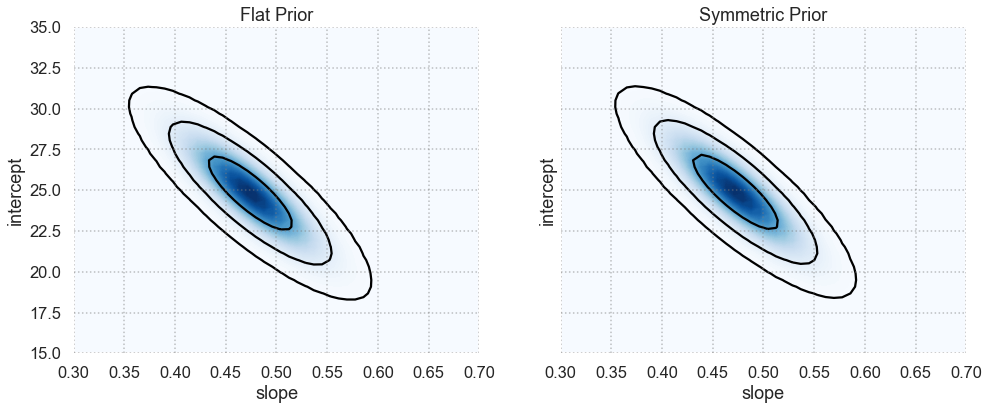

In [11]:
plot_results(x, y, dy)

*What do you conclude about how the form of the prior affects the final posterior in this case?*

A general observation that often ends up being the case: for all the worrying about the effect of the prior, when you have enough data to constrain your model well, the prior has very little effect.

Let's use some different data and see what happens:

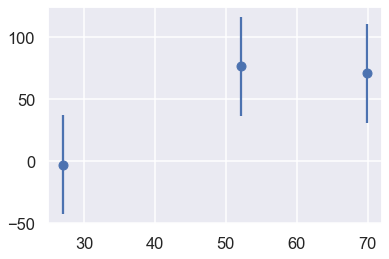

In [12]:
x2, y2, dy2 = make_data(*theta_true, N=3, dy=40, rseed=80)
plt.errorbar(x2, y2, dy2, fmt='o');

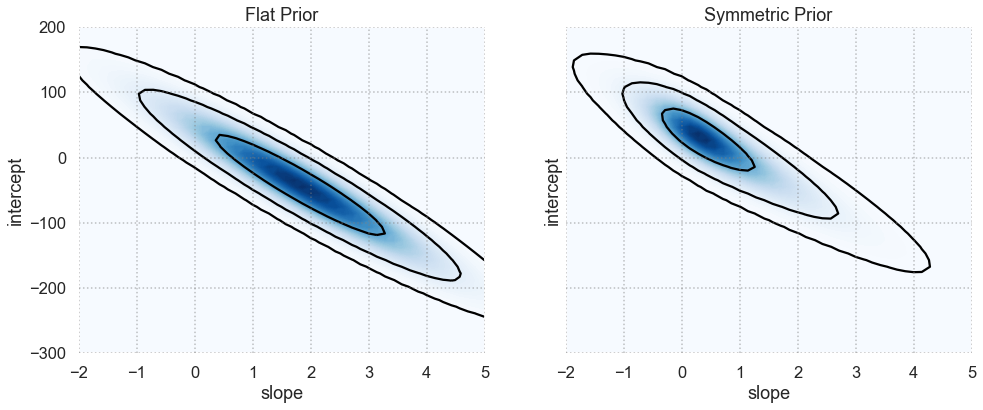

In [13]:
plot_results(x2, y2, dy2,
             slope_limits=(-2, 5),
             intercept_limits=(-300, 200))

*Why in this case does the form of the prior have a clear effect?*


This encodes exactly what you would scientifically expect: if you don't have very good data, it is unlikely to change your views of the world (which are of course encoded in the prior).